# Import Library

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Processed Data

In [17]:
sns.set(style="whitegrid")

PROCESSED_DIR = "../data/processed"

df = pd.read_csv(f"{PROCESSED_DIR}/electricity_clean.csv")

df.head()

,province,electricity_gwh,year
0,Aceh,2937.99,2020
1,Bali,4946.86,2020
2,Banten,22268.71,2020
3,Bengkulu,1013.50,2020
4,Di Yogyakarta,3012.45,2020


# Struktur Data & Validasi Dasar

In [18]:
df.info()
print("\nMissing values:")
print(df.isna().sum())

print("\nUnique values:")
print(df.nunique())

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   province         136 non-null    object 
 1   electricity_gwh  136 non-null    float64
 2   year             136 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ KB

Missing values:
province           0
electricity_gwh    0
year               0
dtype: int64

Unique values:
province            34
electricity_gwh    136
year                 4
dtype: int64


,electricity_gwh,year
count,136.000000,136.000000
mean,7803.213971,2021.500000
std,12719.055679,1.122167
min,184.500000,2020.000000
25%,1195.222500,2020.750000
50%,2938.495000,2021.500000
75%,5791.010000,2022.250000
max,58564.310000,2023.000000


# Cek Konsistensi Data (Wajib)

In [19]:
consistency = df.groupby("province")["year"].nunique().reset_index()
missing = consistency[consistency["year"] != 4]
missing

,province,year


# Distribusi Konsumsi (Baseline)

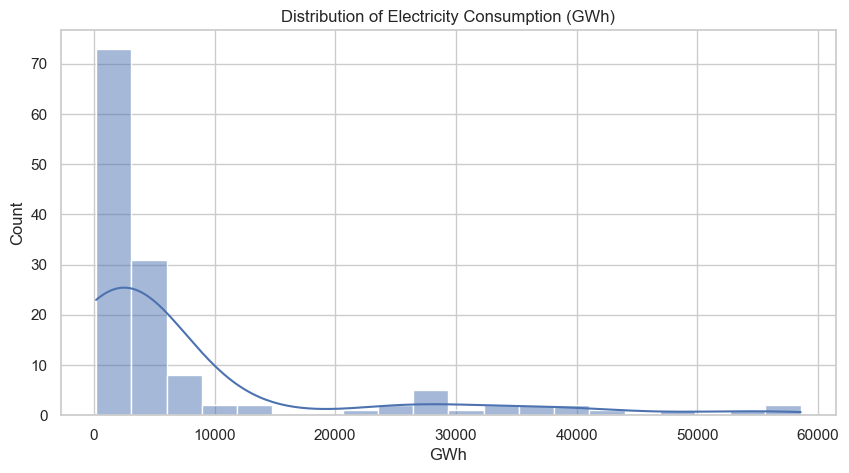

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df["electricity_gwh"], bins=20, kde=True)
plt.title("Distribution of Electricity Consumption (GWh)")
plt.xlabel("GWh")
plt.ylabel("Count")
plt.show()

# Konsumsi Rata-Rata per Provinsi (2020–2023)

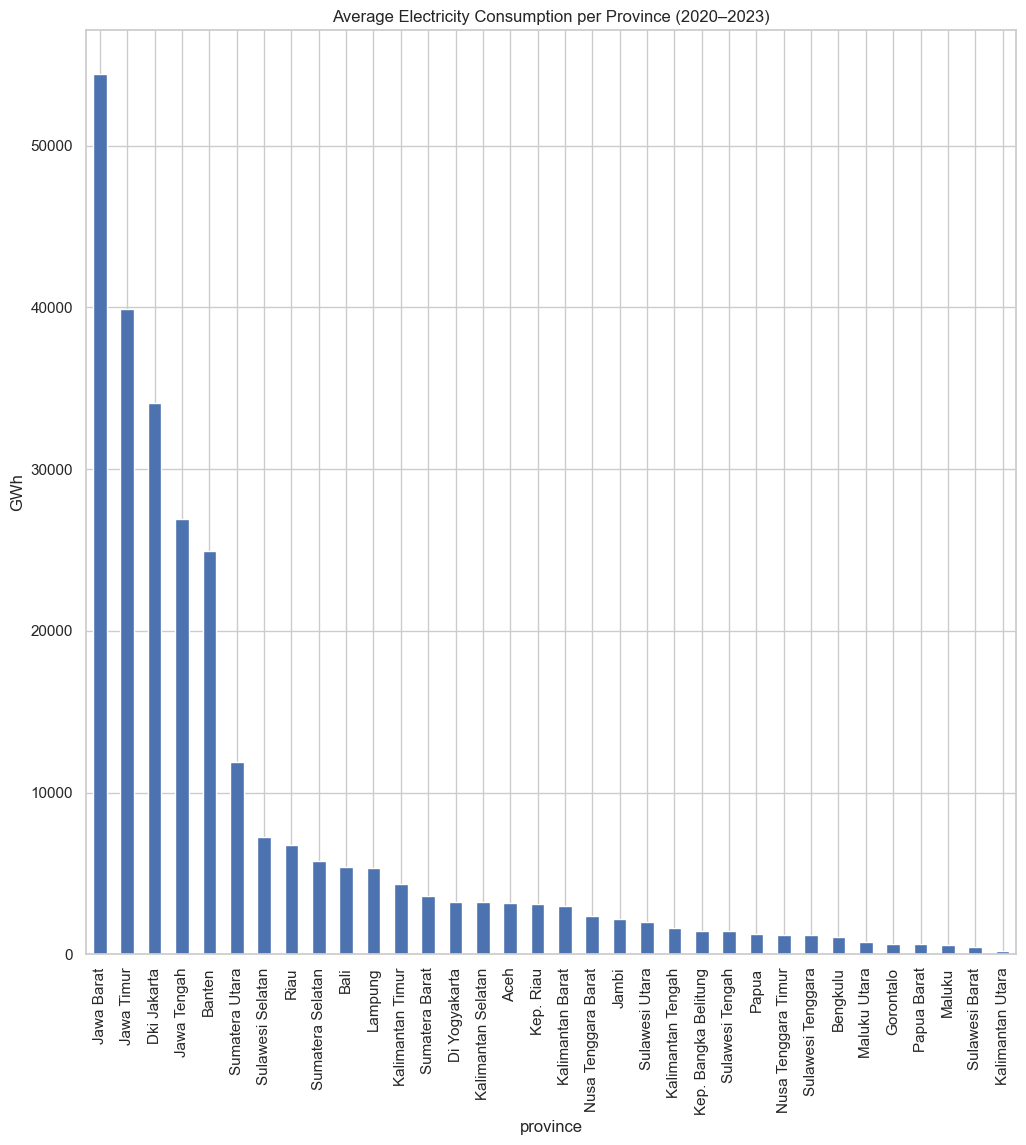

In [21]:
avg_province = (
    df.groupby("province")["electricity_gwh"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(12,12))
avg_province.plot(kind="bar")
plt.title("Average Electricity Consumption per Province (2020–2023)")
plt.ylabel("GWh")
plt.show()

# Heatmap (Provinsi × Tahun)

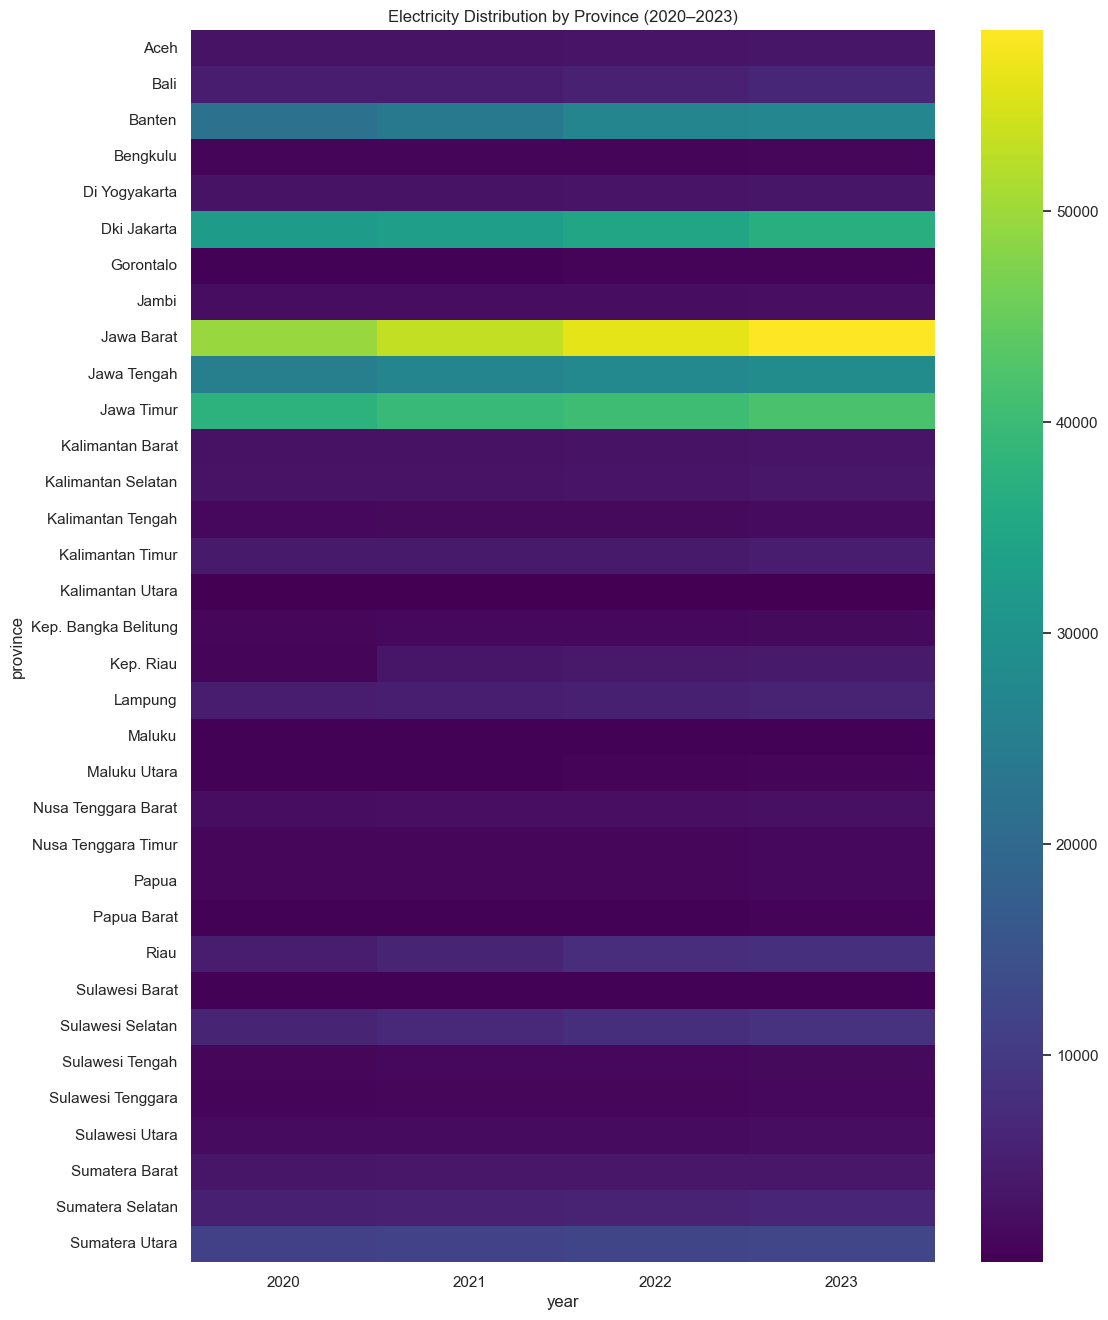

In [22]:
pivot = df.pivot(index="province", columns="year", values="electricity_gwh")

plt.figure(figsize=(12,16))
sns.heatmap(pivot, cmap="viridis", annot=False)
plt.title("Electricity Distribution by Province (2020–2023)")
plt.show()

# Tren Nasional 2020–2023

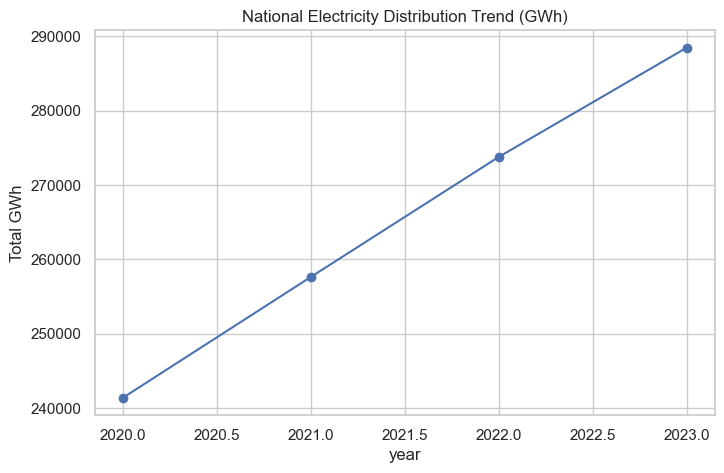

year
2020    241405.61
2021    257634.26
2022    273761.48
2023    288435.75
Name: electricity_gwh, dtype: float64

In [23]:
trend = df.groupby("year")["electricity_gwh"].sum()

plt.figure(figsize=(8,5))
trend.plot(marker="o")
plt.title("National Electricity Distribution Trend (GWh)")
plt.ylabel("Total GWh")
plt.show()

trend

# Tren per Provinsi (Line Chart)

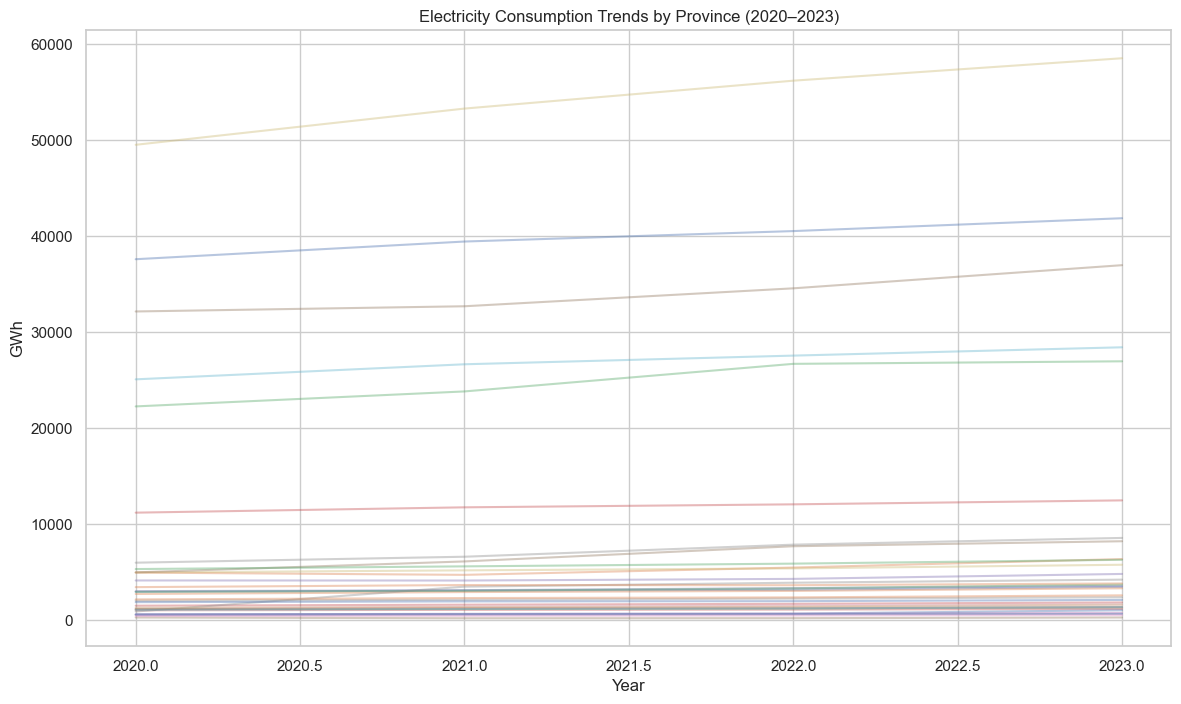

In [24]:
plt.figure(figsize=(14,8))

for prov in df["province"].unique():
    subset = df[df["province"] == prov]
    plt.plot(subset["year"], subset["electricity_gwh"], alpha=0.4)

plt.title("Electricity Consumption Trends by Province (2020–2023)")
plt.xlabel("Year")
plt.ylabel("GWh")
plt.show()

# Yearly Growth Rate per Province (PENTING)

In [25]:
df_sorted = df.sort_values(["province", "year"])
df_sorted["pct_change"] = df_sorted.groupby("province")["electricity_gwh"].pct_change() * 100

df_sorted.head()

,province,electricity_gwh,year,pct_change
0,Aceh,2937.99,2020,NaN
34,Aceh,3074.47,2021,4.645353
68,Aceh,3154.01,2022,2.587113
102,Aceh,3458.30,2023,9.647718
1,Bali,4946.86,2020,NaN


### Distribusi growth:

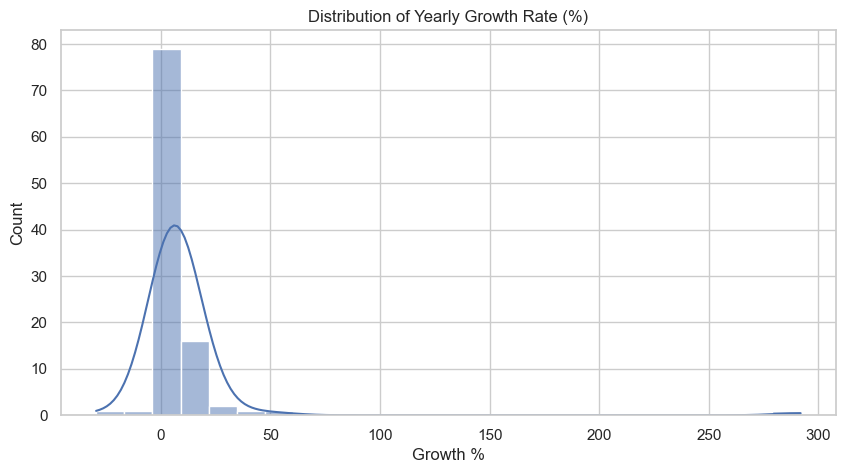

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(df_sorted["pct_change"].dropna(), bins=25, kde=True)
plt.title("Distribution of Yearly Growth Rate (%)")
plt.xlabel("Growth %")
plt.show()

# Top Positive & Negative Growth (Insight Inti)

In [27]:
growth_summary = (
    df_sorted.groupby("province")["pct_change"]
    .mean()
    .sort_values(ascending=False)
)

print("Top Growth Provinces:")
print(growth_summary.head(10))

print("\nLowest (Negative) Growth Provinces:")
print(growth_summary.tail(10))

Top Growth Provinces:
province
Kep. Riau               103.983354
Maluku Utara             21.586554
Riau                     18.556692
Sulawesi Selatan         12.794857
Kep. Bangka Belitung      9.795902
Bali                      9.175726
Sulawesi Tenggara         8.106226
Sulawesi Tengah           8.093028
Kalimantan Selatan        7.969746
Gorontalo                 7.272867
Name: pct_change, dtype: float64

Lowest (Negative) Growth Provinces:
province
Lampung             5.138023
Maluku              4.951777
Dki Jakarta         4.794049
Bengkulu            4.492327
Jawa Tengah         4.264482
Sulawesi Utara      4.031569
Kalimantan Utara    3.838159
Sumatera Utara      3.679647
Jawa Timur          3.655540
Sumatera Barat      3.620698
Name: pct_change, dtype: float64


# Anomaly Detection (Lonjakan Tidak Wajar)

In [28]:
anomaly = df_sorted[
    (df_sorted["pct_change"] > 50) | 
    (df_sorted["pct_change"] < -50)
]

anomaly

,province,electricity_gwh,year,pct_change
51,Kep. Riau,3478.63,2021,291.914151
122,Maluku Utara,1018.52,2023,51.493337


# Variability (Coefficient of Variation)

In [29]:
cv = (
    df.groupby("province")["electricity_gwh"]
    .agg(lambda x: x.std() / x.mean())
    .sort_values(ascending=False)
)

cv.head(10)

province
Kep. Riau               0.486350
Maluku Utara            0.267620
Riau                    0.220177
Kalimantan Utara        0.190407
Sulawesi Selatan        0.161765
Bali                    0.135854
Kep. Bangka Belitung    0.117875
Kalimantan Selatan      0.103077
Sulawesi Tengah         0.099958
Sulawesi Tenggara       0.098683
Name: electricity_gwh, dtype: float64

# Ranking Provinsi per Tahun

In [30]:
df_rank = df.copy()
df_rank["rank"] = df_rank.groupby("year")["electricity_gwh"].rank(ascending=False)

df_rank.head()

,province,electricity_gwh,year,rank
0,Aceh,2937.99,2020,16.0
1,Bali,4946.86,2020,11.0
2,Banten,22268.71,2020,5.0
3,Bengkulu,1013.50,2020,27.0
4,Di Yogyakarta,3012.45,2020,14.0


### Visualisasi:

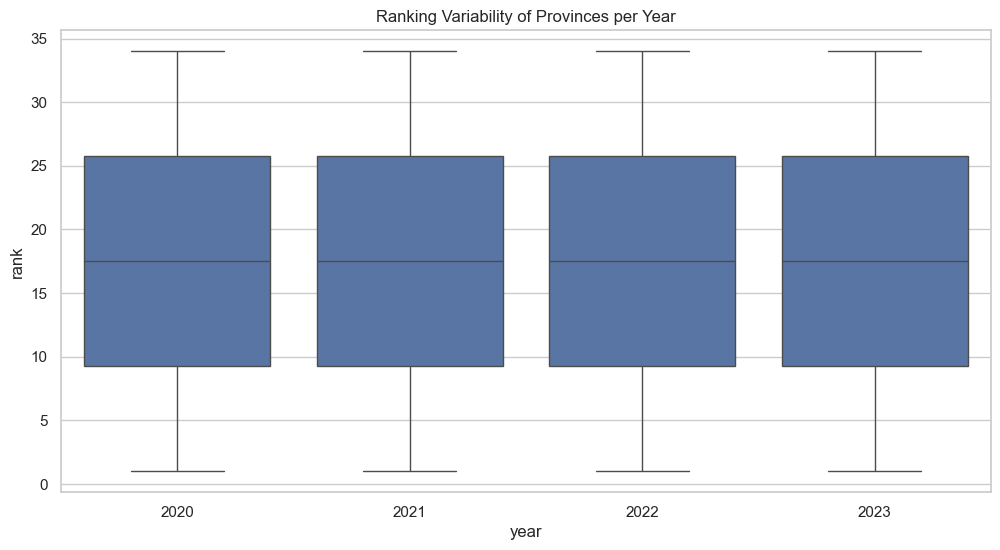

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_rank, x="year", y="rank")
plt.title("Ranking Variability of Provinces per Year")
plt.show()

# Share (%) dari Konsumsi Nasional

In [32]:
national_total = df.groupby("year")["electricity_gwh"].sum().rename("national")

df_share = df.merge(national_total, on="year")
df_share["share_pct"] = (df_share["electricity_gwh"] / df_share["national"]) * 100

df_share.head()

,province,electricity_gwh,year,national,share_pct
0,Aceh,2937.99,2020,241405.61,1.217035
1,Bali,4946.86,2020,241405.61,2.049190
2,Banten,22268.71,2020,241405.61,9.224603
3,Bengkulu,1013.50,2020,241405.61,0.419833
4,Di Yogyakarta,3012.45,2020,241405.61,1.247879


### Distribusi share:

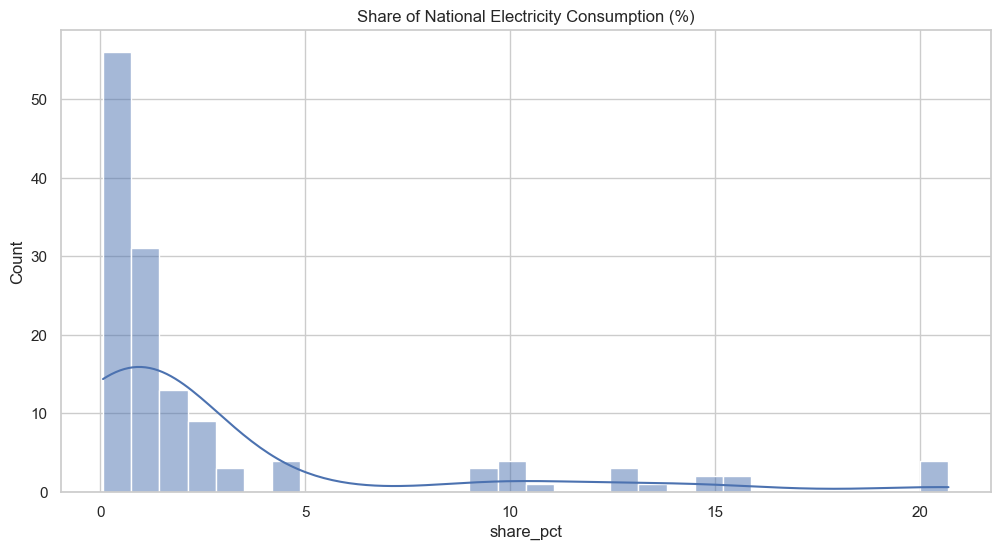

In [33]:
plt.figure(figsize=(12,6))
sns.histplot(df_share["share_pct"], bins=30, kde=True)
plt.title("Share of National Electricity Consumption (%)")
plt.show()

# Korelasi Antar Tahun (Year-to-Year)

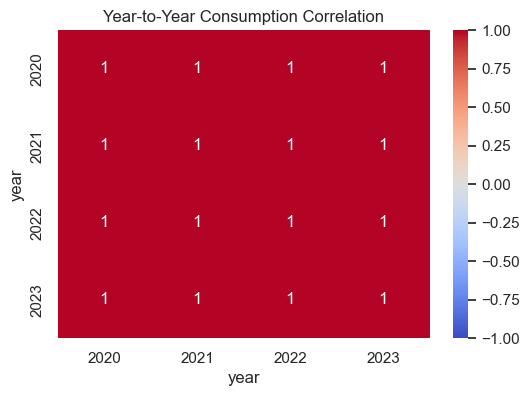

In [34]:
corr = pivot.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Year-to-Year Consumption Correlation")
plt.show()